In [1]:
### GENERAL CONFIGURATION FOR THE ANALYSIS:
# Imports
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


sys.path.append(os.getcwd().strip('notebooks') + 'src/')
import WGCNA_functions as wgcnax



# Colors for the terminal outputs
ENDC = "\033[0m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"

OKBLUE = "\033[94m"
OKGREEN = "\033[92m"
WARNING = "\033[93m"
FAIL = "\033[91m"

# Settings for printing dataframes
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)


### LOADING REAL UNPUBLISHED DATA    -     NO PUSHING FOR THE RESULTS

# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')
data_dir = working_dir + 'data/PROTECTED_DATA/BGI_Expression_Data/'



## Load the dataset
# Transcriptomics Data 
transcriptomics_TPM_dataset_dir = data_dir + 'CRC.SW.mRNA.symbol.TPM.csv'  
transcriptomics_dataset = pd.read_csv(transcriptomics_TPM_dataset_dir, index_col=0)

# Sample info and Clinical Traits Data
sample_info_traits_dir = data_dir + 'Sample_Info_Selection.csv'
trait_dataset = pd.read_csv(sample_info_traits_dir, index_col=0)
trait_dataset


# Figures Saving output dir
figures_dir = working_dir + 'results/testing/'

# Check if the directory exists, and if not, create it
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"{BOLD}{OKBLUE}Creating directory to save results and figures...{ENDC}")


In [2]:
### PARAMETERS

# SETTINGS FOR PLOTTING FIGURES
want_plots = True

# Step 1.
expression_th = 1           # Preprocessing expression threshold

# Step 3.
RsquaredCut = 0.8
MeanCut = 100
block_size_scalefit = 10
adjacency_type = "unsigned"

# Step 4.
TOMDenom = "mean"

# Step 6.
min_memb_cluster = 15
height_percentile = 60  # Use the percentile of heights to set sensitivity

Step 1
Pre-processing...
preprocess_TPM_outlier_deletion function removed 1431 genes
preprocess_TPM_outlier_deletion function removed 11 pacients
Done...
		The function preprocess_TPM_outlier_deletion ran in 15.46 seconds.


Step 2
Calculating Correlation Matrix...
Done...
Plotting and Saving Gene Expression Correlation Matrix Heatmap...


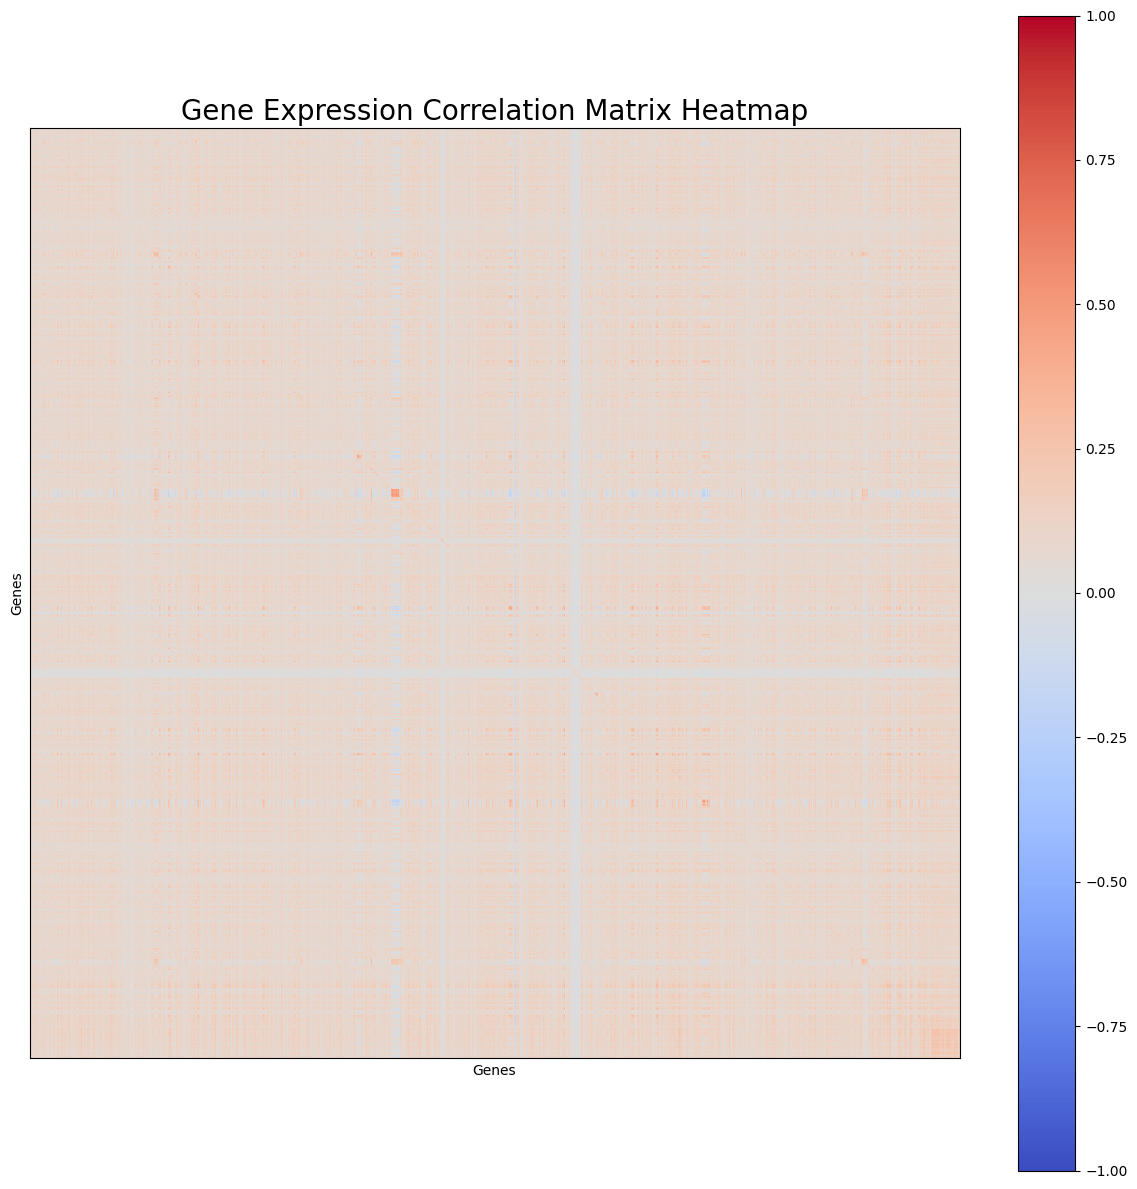

Done
		The function plot_heatmap ran in 30.42 seconds.
		The function correlation_matrix ran in 36.80 seconds.
The matrix satisfies all restrictions.


Step 3
   Power        R²     Slope  Exponential R² Adjusted  mean(connectivity)  median(connectivity)  max(connectivity)
1      1  0.039620  0.259786                 0.316273         2745.648345           2821.160546        4947.158533
2      2  0.341641 -0.867005                 0.637254          740.929941            688.929968        2100.585482
3      3  0.613469 -1.290859                 0.819456          269.205931            208.988101        1086.419627
4      4  0.700915 -1.690488                 0.836742          117.717794             72.821443         678.358083
5      5  0.770665 -1.807085                 0.887161           58.553068             28.084056         462.843569
6      6  0.811505 -1.820906                 0.918028           32.044780             11.775270         332.751145
7      7  0.836280 -1.790087        

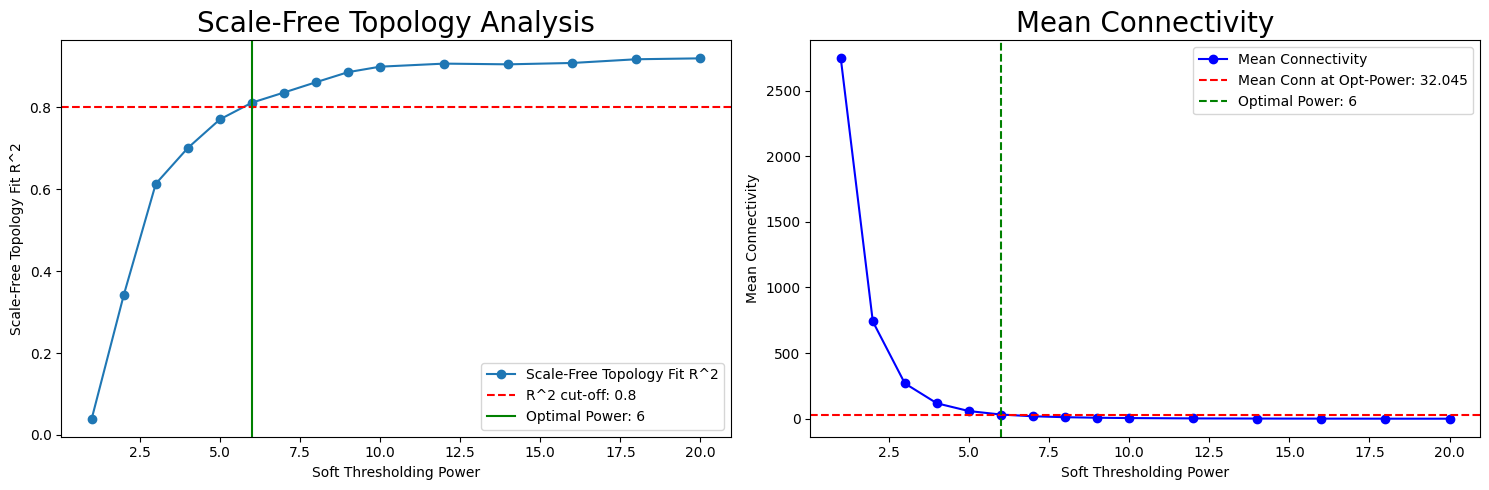

Done

		The function pickSoftThreshold ran in 110.43 seconds.
Calculating Adjacency Matrix...
Done


Plotting and Saving Adjacency Matrix Heatmap...


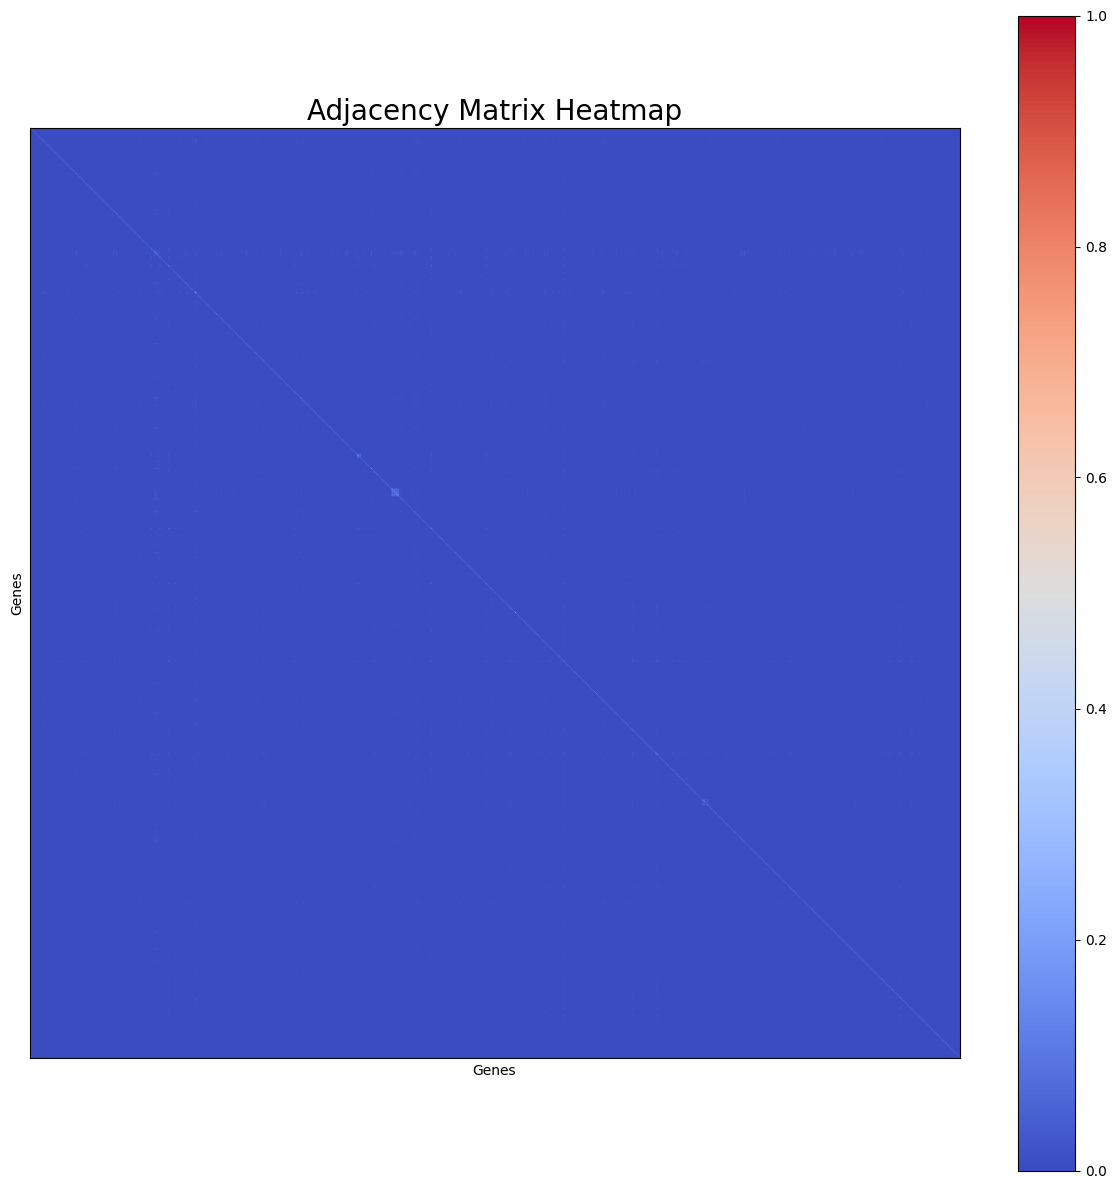

Done
		The function plot_heatmap ran in 30.07 seconds.
		The function adjacencyM_from_correlationM ran in 38.63 seconds.
The matrix satisfies all restrictions.


Step 4
Calculating the TOM...
Done...
Plotting and Saving Topological Overlap Matrix (TOM) Heatmap...


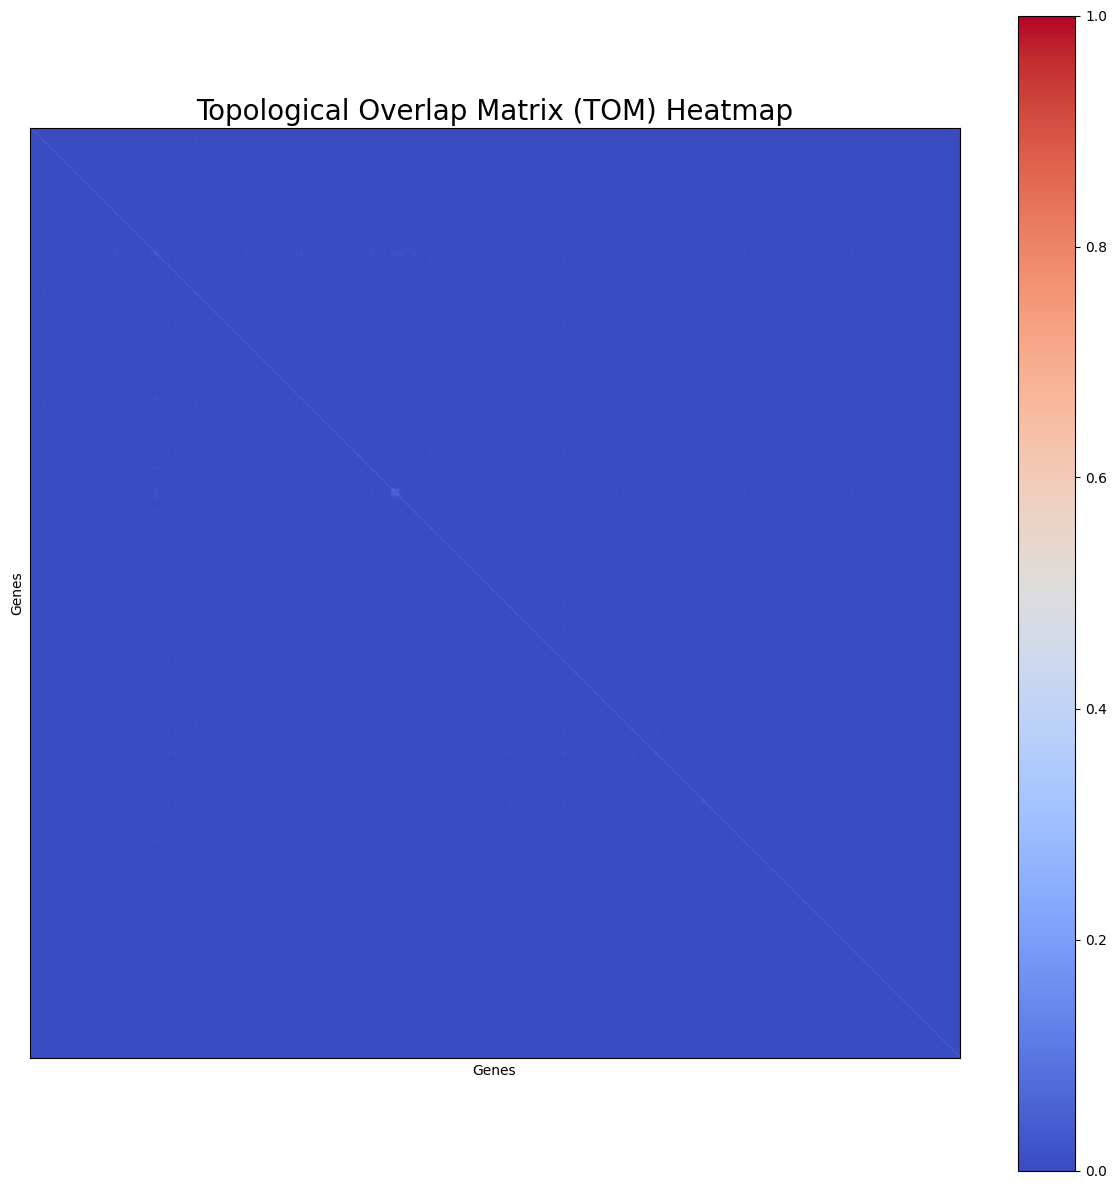

Done
		The function plot_heatmap ran in 29.94 seconds.
		The function calculate_tom ran in 95.67 seconds.
The matrix satisfies all restrictions.


Step 5
Doing Hierarchical clustering over the dissimilarity TOM (1-TOM)...
Done...


Plotting and Saving Dendogram from the Hierarchical clustering...


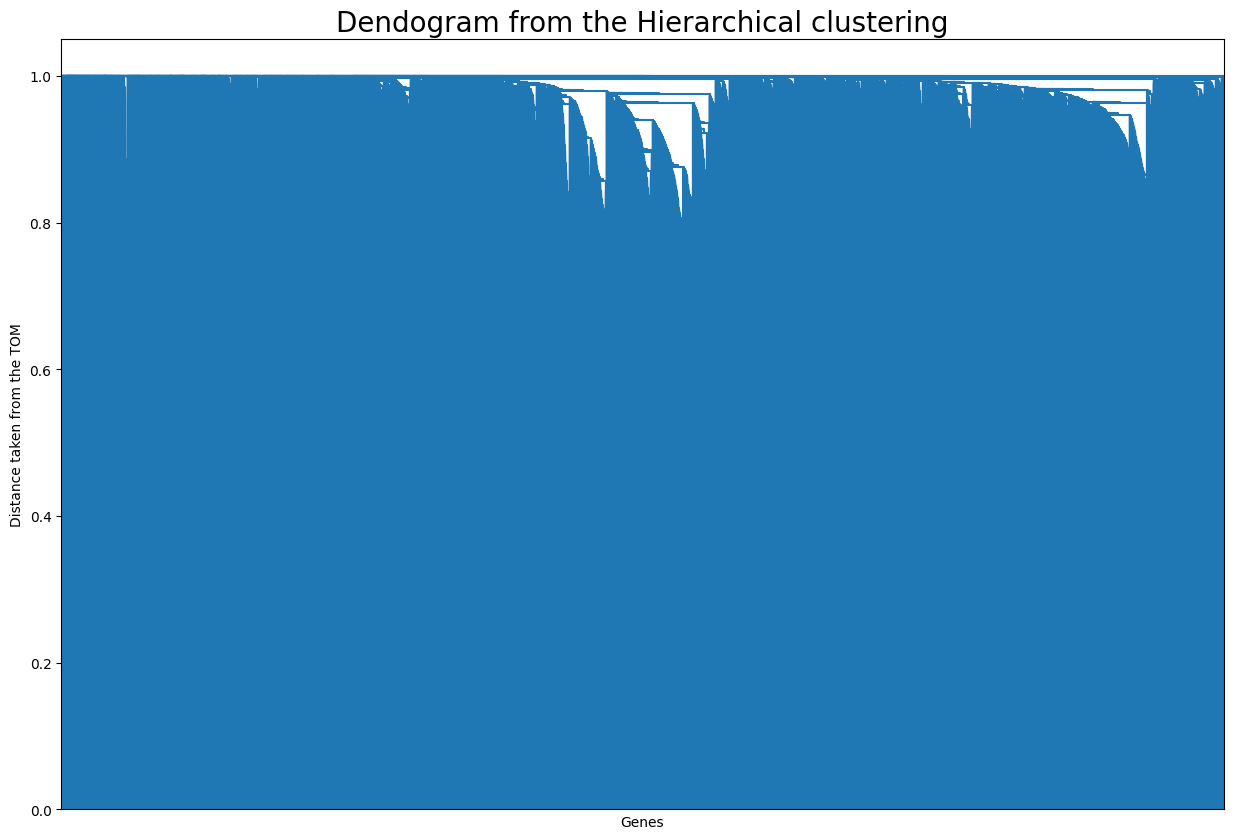

Done
		The function hierarchical_clustering ran in 36.13 seconds.


Step 6
Finding Modules from the Dendogram with a Tree-Cutting Algorithm...
		The function identify_modules_simple_version ran in 0.05 seconds.


Step 7
Calculating EigenGenes...
Done


Plotting and Saving the Eigengene Expression Profile Across Samples...


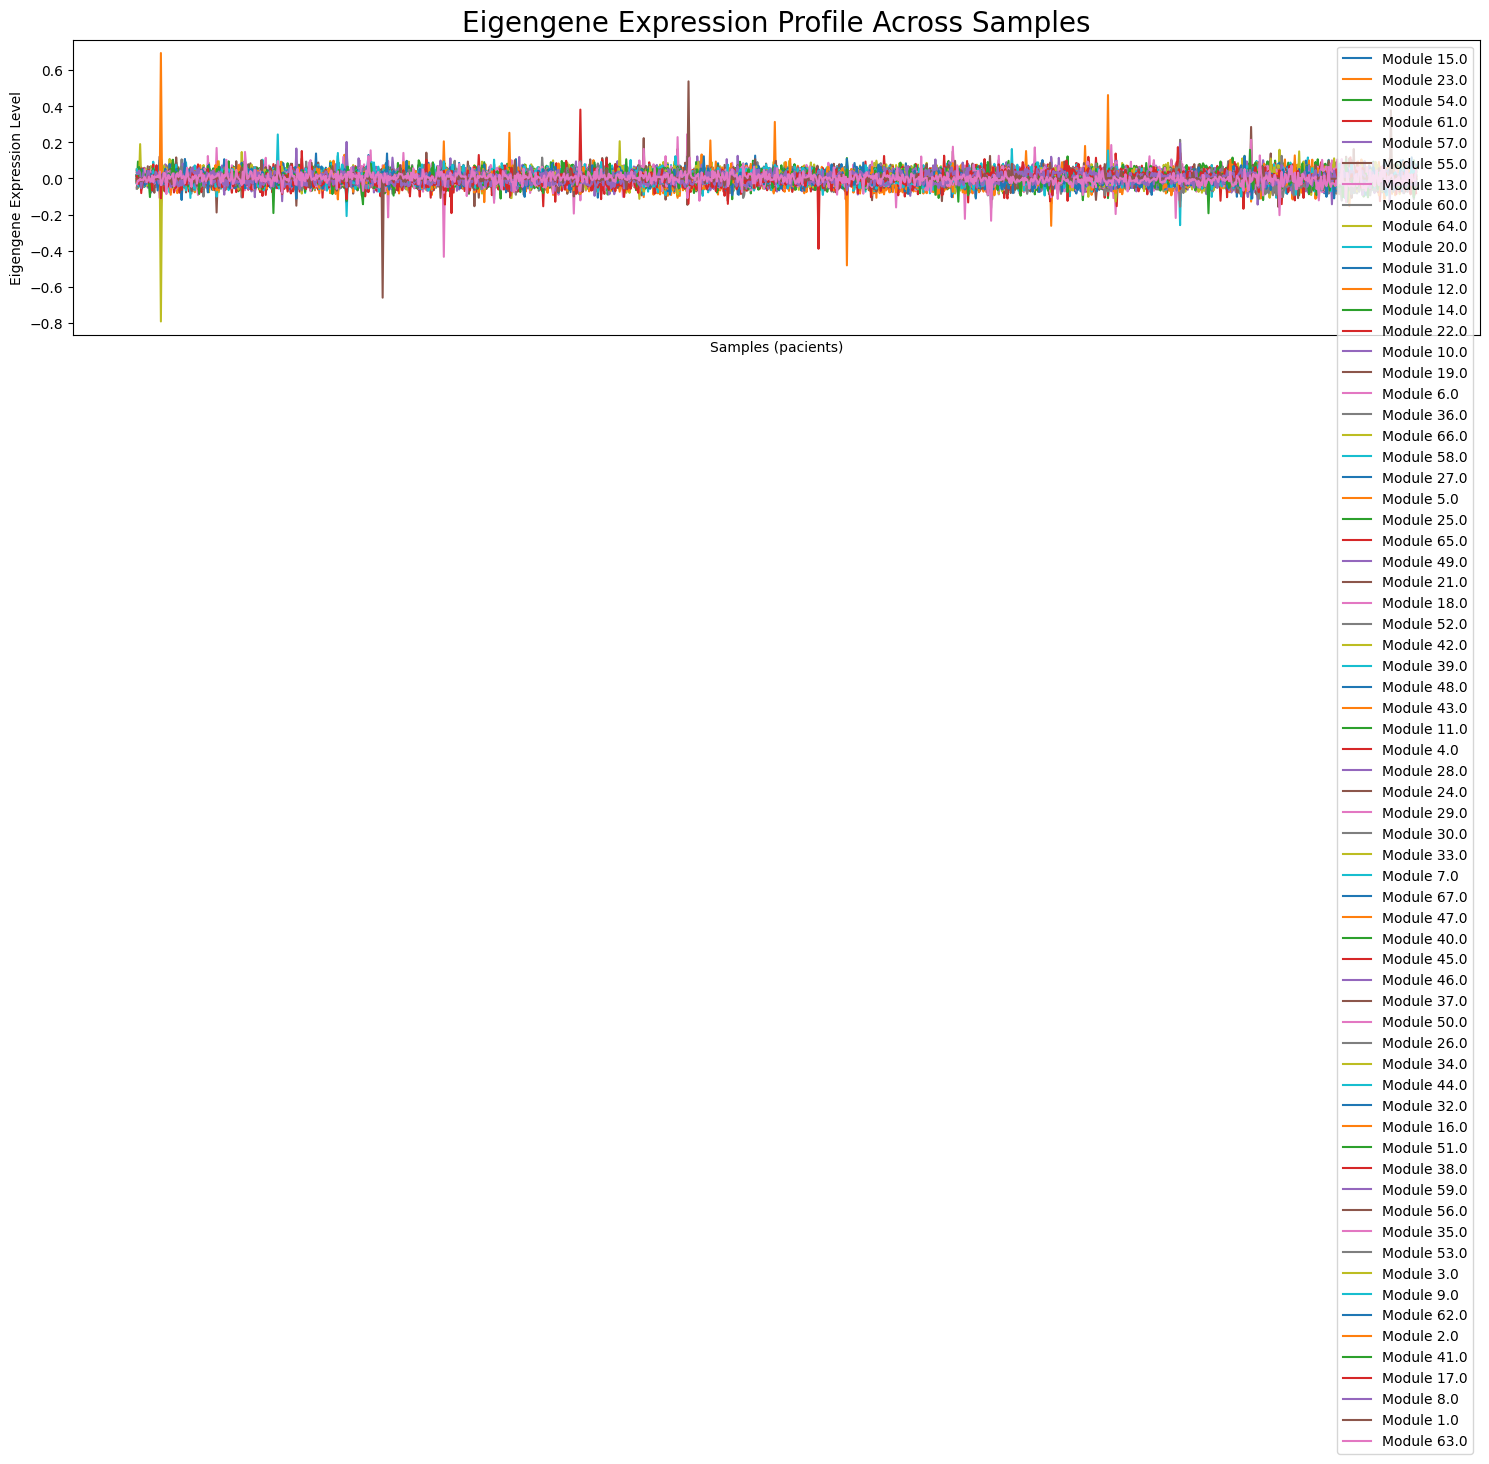

Done
		The function calculate_eigen_genes ran in 6.67 seconds.


Step 8
		The function calculate_correlations ran in 0.78 seconds.
Done




In [3]:
### Step 1: Data Preprocessing (Normalization)
print(f"{BOLD}{OKBLUE}Step 1{ENDC}")
transcriptomics_dataset_filtered, trait_dataset_filtered = wgcnax.preprocess_TPM_outlier_deletion(transcriptomics_dataset, expression_th, trait_dataset)


### Step 2: Constructing a Co-expression Similarity Matrix (Correlation Matrix)
print(f"{BOLD}{OKBLUE}\n\nStep 2{ENDC}")
correlation_matrix_np = wgcnax.correlation_matrix(transcriptomics_dataset_filtered, want_plots, figures_dir)
wgcnax.matrix_np_check(correlation_matrix_np, 1, -1, 1)


### Step 3: Transforming into an adjacency matrix using a soft threshold power
print(f"{BOLD}{OKBLUE}\n\nStep 3{ENDC}")
optimal_power = wgcnax.pickSoftThreshold(correlation_matrix_np, transcriptomics_dataset_filtered, RsquaredCut, MeanCut, True, figures_dir, block_size_scalefit)

adjacency_matrix_np = wgcnax.adjacencyM_from_correlationM(correlation_matrix_np, optimal_power, adjacency_type, want_plots, figures_dir)
wgcnax.matrix_np_check(adjacency_matrix_np, 1, 0, 1)


### Step 4: Converting adjacency matrix into a topological overlap matrix (TOM)
print(f"{BOLD}{OKBLUE}\n\nStep 4{ENDC}")
simTOM_np = wgcnax.calculate_tom(adjacency_matrix_np, TOMDenom, adjacency_type, want_plots, figures_dir)
dissTOM_np = 1 - simTOM_np
wgcnax.matrix_np_check(simTOM_np, 1, 0, 1)


### Step 5: Hierarchical clustering
print(f"{BOLD}{OKBLUE}\n\nStep 5{ENDC}")
linkage_matrix = wgcnax.hierarchical_clustering(dissTOM_np, want_plots, figures_dir)


### Step 6: Module identification
print(f"{BOLD}{OKBLUE}\n\nStep 6{ENDC}")
module_assignment, cut_height = wgcnax.identify_modules_simple_version(linkage_matrix, height_percentile, min_memb_cluster)
module_assignment.insert(0, 'Gene Name', list(transcriptomics_dataset_filtered))


### Step 7: Calculate EigenGenes for all identified Modules
print(f"{BOLD}{OKBLUE}\n\nStep 7{ENDC}")
expression_profiles = wgcnax.expression_profile_for_cluster(module_assignment, transcriptomics_dataset_filtered)

eigen_genes = wgcnax.calculate_eigen_genes(expression_profiles, want_plots, figures_dir)


# Step 8
print(f"{BOLD}{OKBLUE}\n\nStep 8{ENDC}")
trait_columns = list(trait_dataset_filtered.columns[1:] )
correlations, p_values = wgcnax.calculate_correlations(eigen_genes, trait_dataset_filtered, trait_columns)


print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")

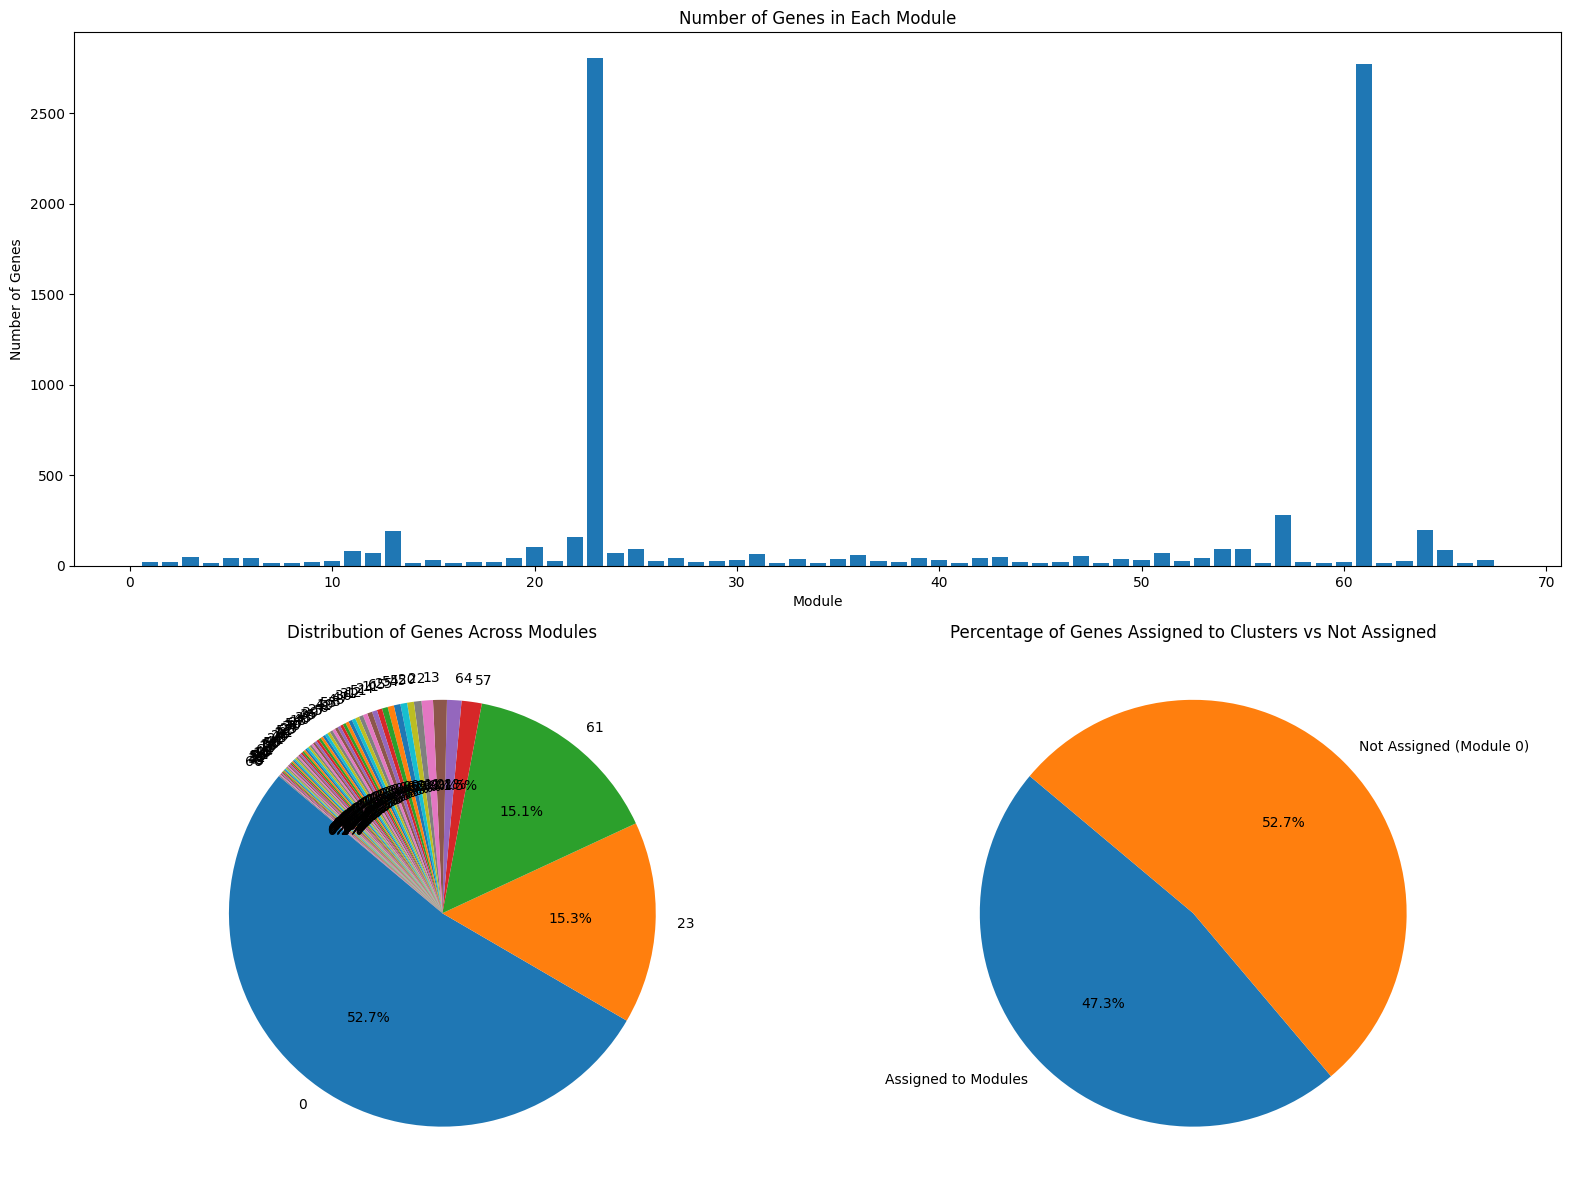

Plotting and Saving the Module EigenGene to Clinical Trait Correlation...


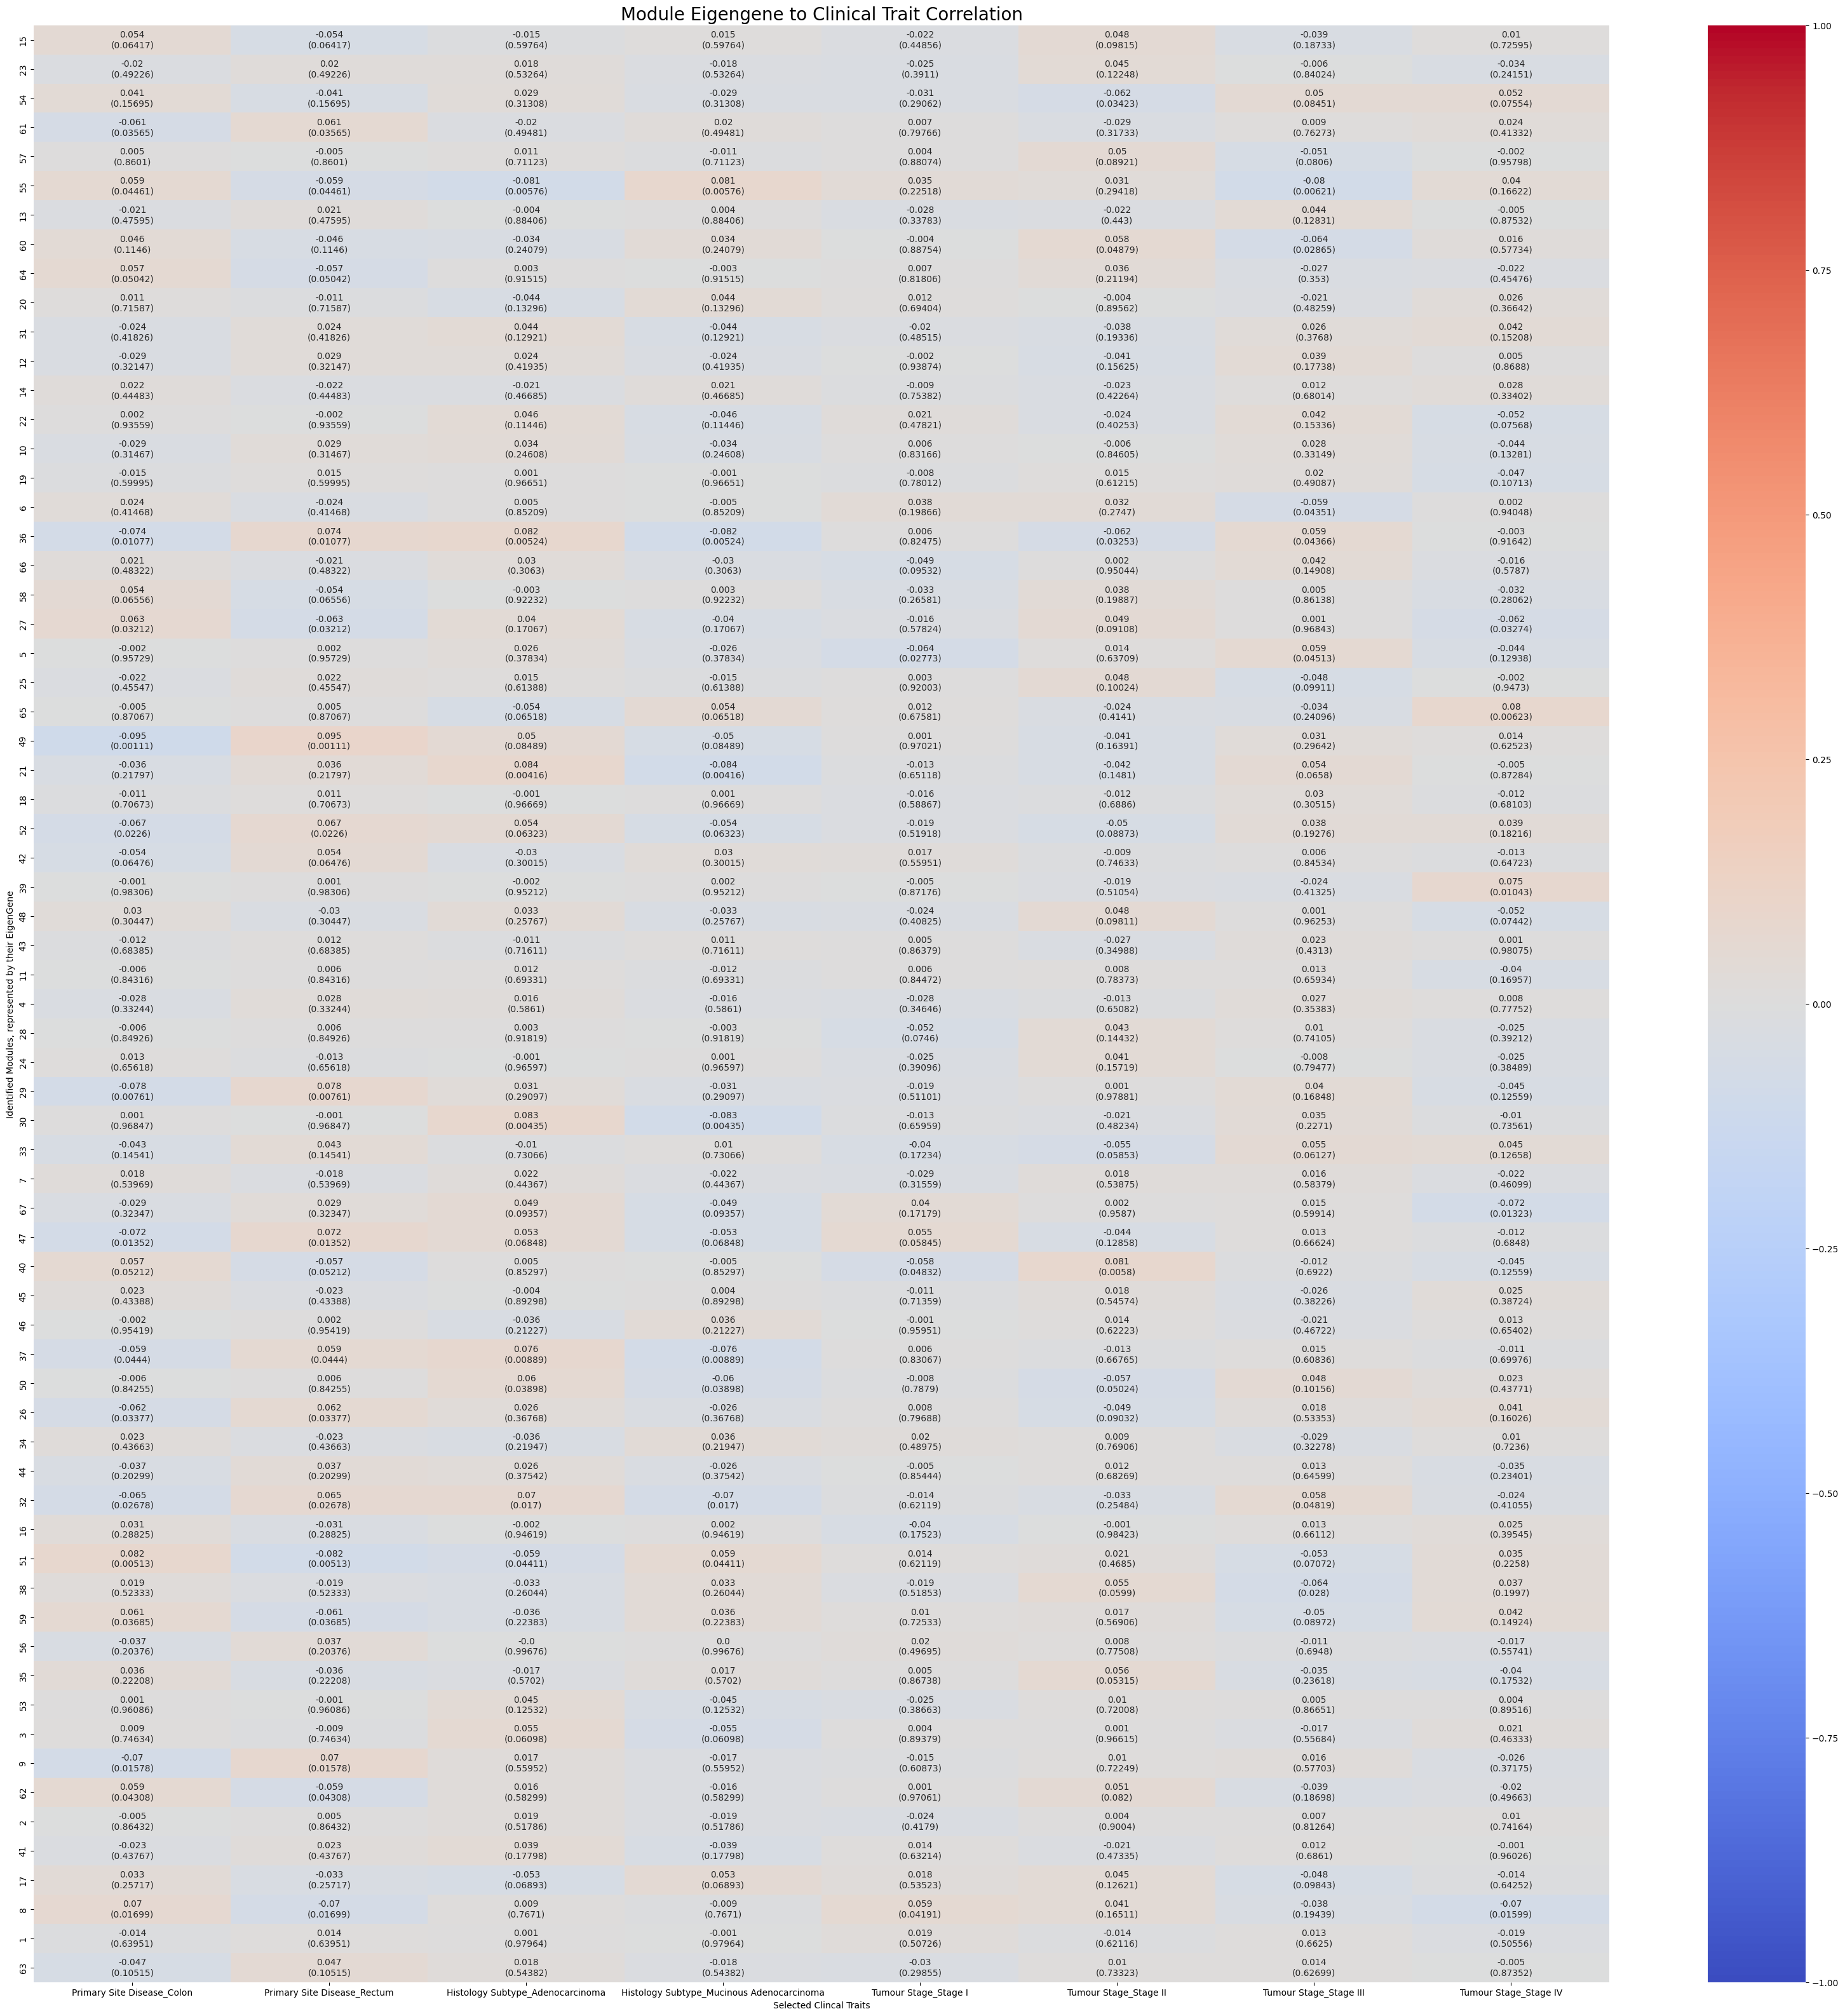

Done


In [4]:
### Visualizations
# Plot visualization of clustersfrom scipy import stats

wgcnax.plot_module_distribution(module_assignment)


## Plot the HEatmap
print(f"{BOLD}{OKBLUE}Plotting and Saving the Module EigenGene to Clinical Trait Correlation...{ENDC}")
title_figure = 'Module Eigengene to Clinical Trait Correlation'

annotations = correlations.round(3).astype(str) + '\n(' + p_values.round(5).astype(str) + ')'

plt.figure(figsize=(40, 40)) 
sns.heatmap(correlations, annot=annotations.values, fmt='', cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title(title_figure, fontsize=20)
plt.xlabel('Selected Clincal Traits', fontsize=10)
plt.ylabel('Identified Modules, represented by their EigenGene', fontsize=10)
plt.savefig(figures_dir + title_figure, dpi=150)
plt.show()
print(f"{BOLD}{OKBLUE}Done{ENDC}")

In [ ]:
### PARAMETERS for automatic search

# SETTINGS FOR PLOTTING FIGURES
want_plots = False

# Step 1.
expression_th = [0.5, 1, 2, 3, 4, 5, 7, 10, 15]

# Step 3.
RsquaredCut = [0.75, 0.8, 0.85, 0.9, 0.95]
MeanCut = [50, 75, 100, 125, 150]
block_size_scalefit = [5, 10, 25, 50, 100]
adjacency_type = "unsigned"

# Step 4.
TOMDenom = "mean"

# Step 6.
min_memb_cluster = 15
height_percentile = 60  # Use the percentile of heights to set sensitivity